# Audio Spectrum Display Simulation
This notebook is used to generate sinewayes samples to use them for testing in embedded system. Samples are then transformed using FFT and then visualise. The bins-bands LUT is also available.

For further informations check out [Github](https://github.com/Gieneq/Spectrum_Audio_Display_V2)

## Assumptions

* Sampling frequency: 44 kHz,
* Max frequency in the signal (Nyquist theorem): 22 kHz,
* Numbber of FFT bins: 1024,
* Number of bands: 19,
* Bins to bands assignment function: exponential with variable exponent factor.

The goal is to achieve FFT refreshrate of not **less then 30 Hz**. STM32F4 IC will be used to sample signal with builtin 12 bit ultra-fast SAR ADC.



In [329]:
sampling_frequency = 44e3  # Hz
refresh_rate_cap = 30      # Hz

# Sampling time
More FFT points means longer sampling time. By using 44 kHz sampling rate the overall refresh rate can drop below 30 Hz cap quite fast. It can be avoided by double buffering samples and windowing. In comparison the time of evaluating the FFT on STM32 using the CMSIS library is neglibli short.

Considered FFT resolution: [128, 256, 512, 1024, 2048, 4096]
Refresh rate cap: {128: 344, 256: 172, 512: 86, 1024: 43, 2048: 21, 4096: 11} [points:Hz]
Max FFT points: 1024 with 43 Hz refresh rate.


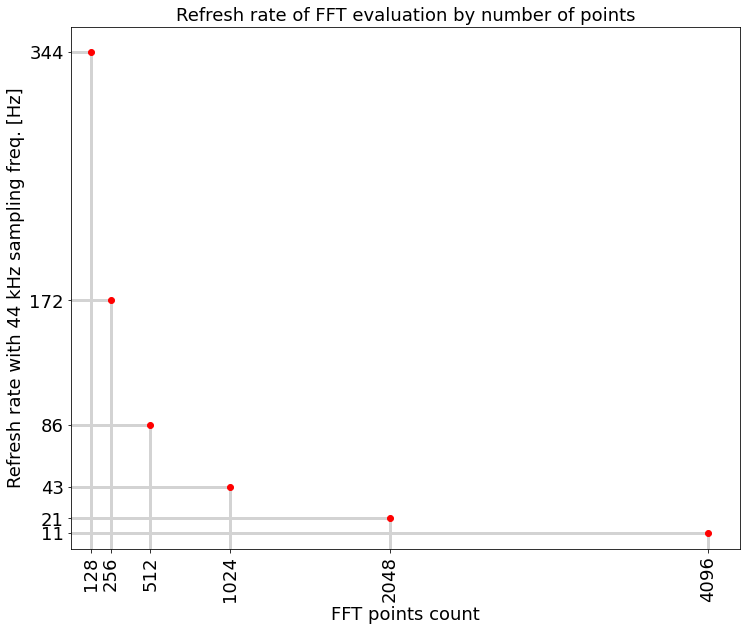

In [330]:
fft_points_options = [2**i for i in range(7,13)]
print(f"Considered FFT resolution: {fft_points_options}")
sampling_time = [1000*points/sampling_frequency for points in fft_points_options]
point_fps_dict = dict(zip(fft_points_options, [round(sampling_frequency/points) for points in fft_points_options]))
freqs_by_ftt_points = list(point_fps_dict.values())
print(f"Refresh rate cap: {point_fps_dict} [points:Hz]")

inv_point_fps_dict = dict(zip(point_fps_dict.values(), point_fps_dict.keys()))
available_options = sorted({val:key for key, val in point_fps_dict.items() if val > refresh_rate_cap}.items(), reverse=False, key=lambda x: x[0])
best_option = available_options[0]
print(f"Max FFT points: {best_option[1]} with {best_option[0]} Hz refresh rate.")


for x, y in zip(fft_points_options, freqs_by_ftt_points):
    plt.plot([x, x],[0,y], color='lightgray', linestyle='-', linewidth=3)
    plt.plot([0, x],[y,y], color='lightgray', linestyle='-', linewidth=3)
    
plt.plot(fft_points_options, freqs_by_ftt_points, "or")

plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xticks(fft_points_options, rotation=90, fontsize= 18)
plt.yticks(freqs_by_ftt_points, fontsize= 18)

plt.xlabel("FFT points count", fontsize=18)
plt.ylabel(f'Refresh rate with {round(sampling_frequency/1000)} kHz sampling freq. [Hz]', fontsize=18)
plt.title(f"Refresh rate of FFT evaluation by number of points", fontsize=18)
plt.show()


# Input signal
Generating input signal with 2 main frequencies and added white noise

Sampling time: 23.27 ms of 1024 samples with 44000.0 sps


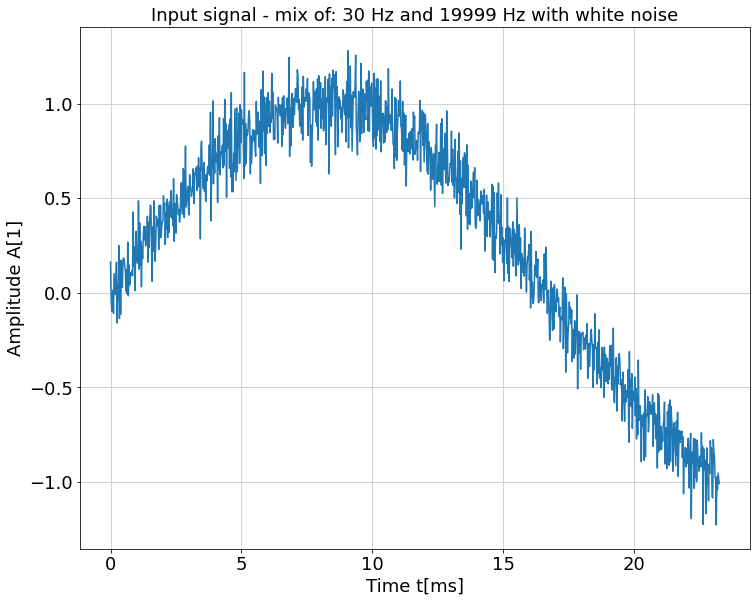

In [331]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import pi

plots_scale = 0.8
plt.rcParams['figure.figsize'] = [plots_scale*15, plots_scale*12]

# Twice as many samples are needed
samples_count = 1024

# Testing frequencies
frequency_1 = 30
frequency_2 = 19999

np.random.seed(1)
noise = np.random.normal(loc=0, scale=0.1, size=samples_count)

sampling_time = samples_count * 1/sampling_frequency
print(f"Sampling time: {round(sampling_time*1000, 2)} ms of {samples_count} samples with {sampling_frequency} sps")

t = np.arange(samples_count)/sampling_frequency
val = np.sin(2*pi*frequency_1*t) + 0.1 * np.sin(2*pi*frequency_2*t) +noise

plt.plot(t*1000, val)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.xlabel("Time t[ms]", fontsize=18)
plt.ylabel(r'Amplitude A[1]', fontsize=18)
plt.title(f"Input signal - mix of: {frequency_1} Hz and {frequency_2} Hz with white noise", fontsize=18)
plt.show()


# FFT Evaluation
Fast Fourier Transformation allows converting time-base samples of the signal to frequency-based magnitudes. The magnitude depict the content of specific frequency in the signal. On the magnitude plot there are visible 2 lobes: on on the left side (low frequencies) one on the right side (higher frequencies).

Mags count: 512


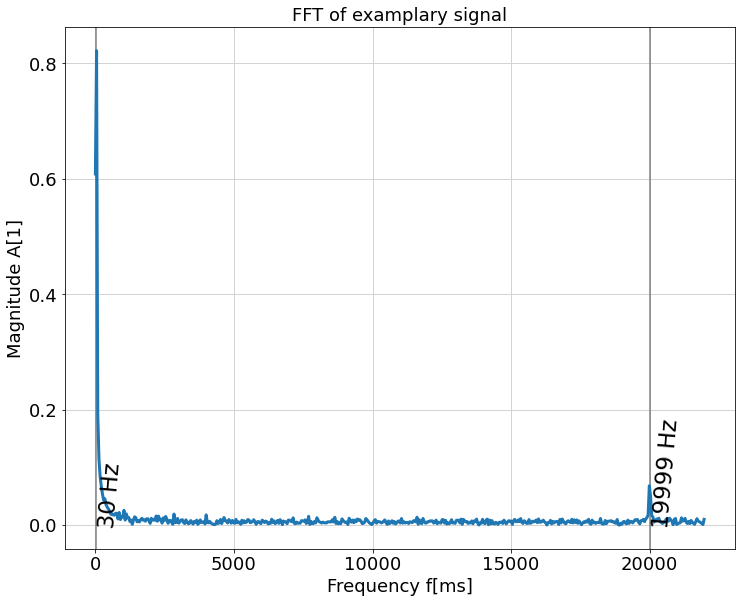

In [332]:
import scipy.fftpack


yf = scipy.fftpack.fft(val)
xf = sampling_frequency*np.arange(samples_count)/samples_count

freqs = xf[:samples_count//2]
mags = 2.0/samples_count * np.abs(yf[:samples_count//2])
print(f"Mags count: {len(mags)}")

sig_fft_real = yf.real
sig_fft_imag = yf.imag

plt.axvline(x=frequency_1, c="gray")
plt.axvline(x=frequency_2, c="gray")
plt.plot(freqs, mags, linewidth=3)
# plt.xscale("log")
# plt.yscale("log")
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.text(frequency_1, 1e-3, f"{frequency_1} Hz", fontsize = 23, rotation=85)
plt.text(frequency_2, 1e-3, f"{frequency_2} Hz", fontsize = 23, rotation=85)
plt.xlabel("Frequency f[ms]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'FFT of examplary signal', fontsize=18)
plt.show()

# Bins and bands

In some cases all resulting FFT magnitude samples are not needed. They can be condensated using bands. Each bands represents specific frequency range in which corresponding frequency magnitudes are added.

To help evalueating this process **bins LUT** (Lookup table) is made.

Worth mentioning is that it is better to use exponential function to calculate bins indices. You can compare it by looking at FFT with or without logscale. Low frequencies are visualised more precisely than higher ones. In contrast, when using the linear function all bands will have the same band widths.


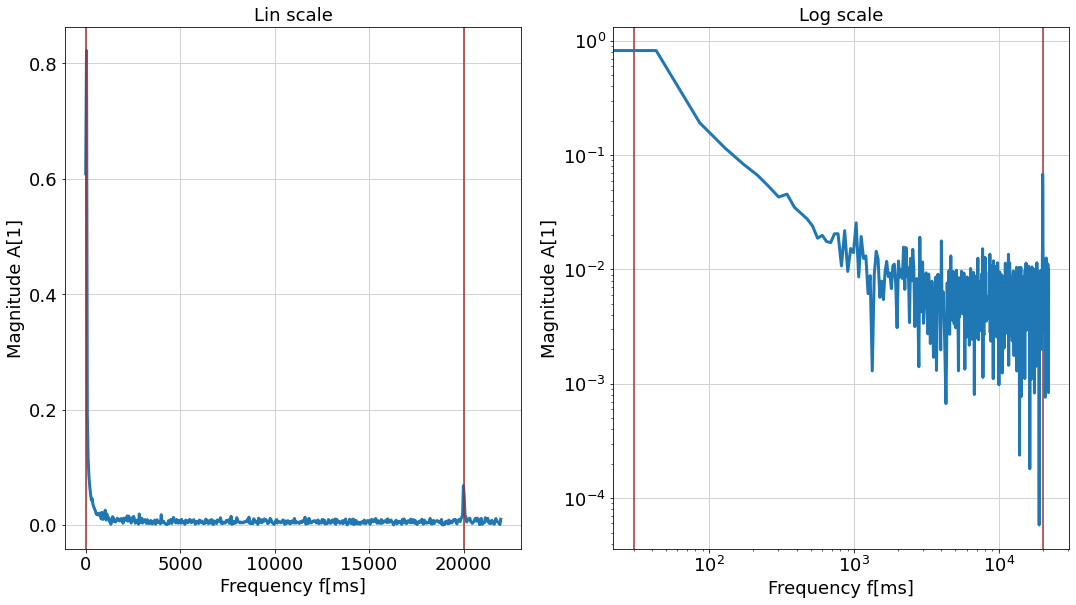

In [333]:
plt.rcParams['figure.figsize'] = [plots_scale*15*1.5, plots_scale*12]

plt.subplot(1, 2, 1)
plt.plot(freqs, mags, linewidth=3)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.axvline(x=frequency_1, c="brown")
plt.axvline(x=frequency_2, c="brown")
plt.xlabel("Frequency f[ms]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'Lin scale', fontsize=18)

plt.subplot(1, 2, 2)
plt.xscale("log")
plt.yscale("log")
plt.axvline(x=frequency_1, c="brown")
plt.axvline(x=frequency_2, c="brown")
plt.plot(freqs, mags, linewidth=3)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
plt.xlabel("Frequency f[ms]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'Log scale', fontsize=18)

plt.show()

plt.rcParams['figure.figsize'] = [plots_scale*15, plots_scale*12]

# Bins function
Using exponential function with variable exponent the suitable convertion can be achieved.

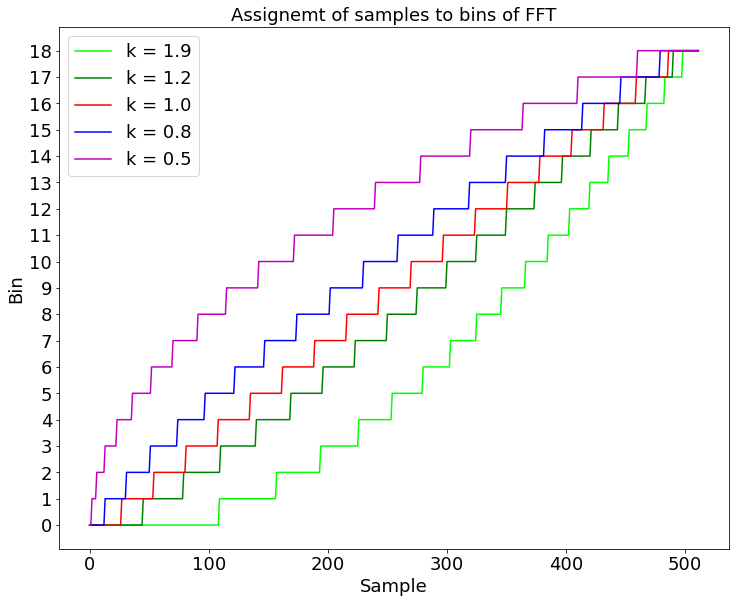

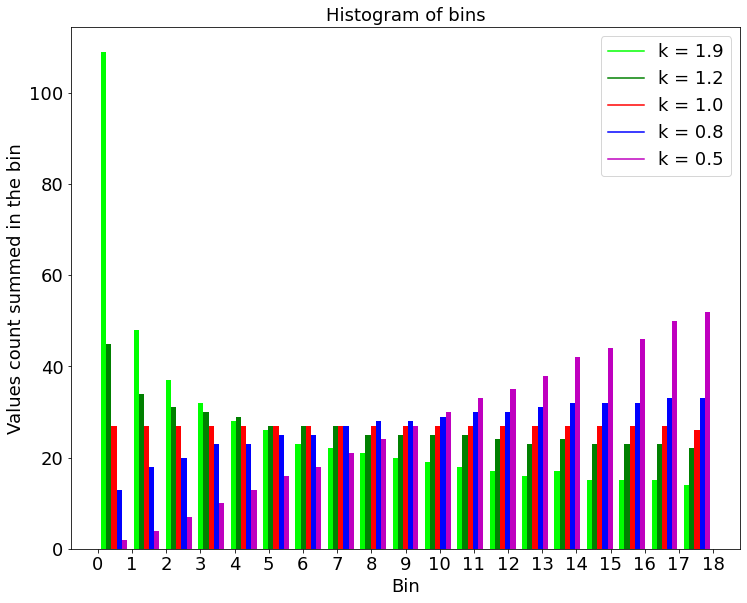

In [334]:
from collections import Counter
from math import floor

bands_count = 19

def gen_bins(bands_count, samples_count, k=1.0):
  return [floor(bands_count*(i/samples_count)**k) for i in range(0, samples_count)]


samples_idx = [i for i in range(0, samples_count // 2)]

k_factors = [1.9, 1.2, 1.0, 0.8, round(1/2, 2)]
plot_colors = ['lime', 'g', 'r', 'b', 'm']
plot_labels = [f"k = {k}" for k in k_factors]
bins_per_k = [gen_bins(bands_count, samples_count // 2, k) for k in k_factors]

plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

lines = [plt.plot(samples_idx, [str(bin) for bin in bins], plot_colors[idx])[0] for idx, bins in enumerate(bins_per_k)]
plt.title('Assignemt of samples to bins of FFT', fontsize=18)
plt.ylabel('Bin', fontsize=18)
plt.xlabel('Sample', fontsize=18);
plt.legend(lines, plot_labels, fontsize=18)
plt.show()

plt.hist([[str(bin) for bin in bins] for bins in bins_per_k], density=False, bins=bands_count, color=plot_colors, label=plot_labels)  # density=False would make counts
plt.title('Histogram of bins', fontsize=18)
plt.ylabel('Values count summed in the bin', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.legend(lines, plot_labels, fontsize=18)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.show()


# Band width
The **k** factor should be chosen so that the resulting function won't omit any bound. If value of k factor is too low it can happen that bands 0 or 1 won't have any assignment.

Elements per bin:  {0: 2, 1: 4, 2: 7, 3: 10, 4: 13, 5: 16, 6: 18, 7: 21, 8: 24, 9: 27, 10: 30, 11: 33, 12: 35, 13: 38, 14: 42, 15: 44, 16: 46, 17: 50, 18: 52} , total:  512 

Bin 0 from 0.0 Hz to 86.11 Hz, range: 86.11 Hz
Bin 1 from 86.11 Hz to 258.32 Hz, range: 172.21 Hz
Bin 2 from 258.32 Hz to 559.69 Hz, range: 301.37 Hz
Bin 3 from 559.69 Hz to 990.22 Hz, range: 430.53 Hz
Bin 4 from 990.22 Hz to 1549.9 Hz, range: 559.69 Hz
Bin 5 from 1549.9 Hz to 2238.75 Hz, range: 688.85 Hz
Bin 6 from 2238.75 Hz to 3013.7 Hz, range: 774.95 Hz
Bin 7 from 3013.7 Hz to 3917.81 Hz, range: 904.11 Hz
Bin 8 from 3917.81 Hz to 4951.08 Hz, range: 1033.27 Hz
Bin 9 from 4951.08 Hz to 6113.5 Hz, range: 1162.43 Hz
Bin 10 from 6113.5 Hz to 7405.09 Hz, range: 1291.59 Hz
Bin 11 from 7405.09 Hz to 8825.83 Hz, range: 1420.74 Hz
Bin 12 from 8825.83 Hz to 10332.68 Hz, range: 1506.85 Hz
Bin 13 from 10332.68 Hz to 11968.69 Hz, range: 1636.01 Hz
Bin 14 from 11968.69 Hz to 13776.91 Hz, range: 1808.22 Hz
Bin 15 from 13776.9

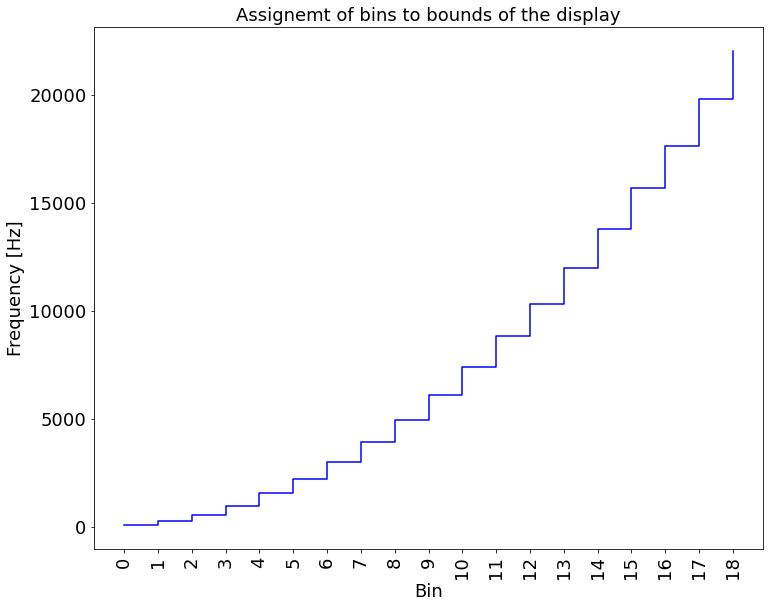

In [335]:
bins_assignment_k = 0.5 #0.45
bins = gen_bins(bands_count, samples_count // 2, bins_assignment_k)

resolution_width = sampling_frequency/2 / (samples_count // 2-1)
# print(f"Single resoolution width: {round(bin_width, 3)} Hz\n")

bins_count = dict(Counter(bins))
print("Elements per bin: ", bins_count, ", total: ", sum(bins_count.values()) , "\n")

plt.xticks(fontsize= 18, rotation=90)
plt.yticks(fontsize= 18)

ranges = [0]*bands_count

for idx in range(bands_count):
  band_width = bins_count[idx] * resolution_width
  ranges[idx] = ranges[idx - 1] + band_width if idx > 0 else band_width
  print(f"Bin {idx} from {round(ranges[idx] - band_width, 2)} Hz to {round(ranges[idx],2)} Hz, range: {round(band_width, 2)} Hz")

# plt.plot([str(bin) for bin in bins], samples_idx, 'r')
plt.step([str(bin) for bin in set(bins)], ranges, 'b', where='post')
plt.title('Assignemt of bins to bounds of the display', fontsize=18)
plt.ylabel('Frequency [Hz]', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.show()




# Audio Spectrum Display Visualization
Resulting values of the bandsare scaled to fit height of the display. In the target system there will be gaincontrol of the audio input signal. In software ther is clipping function so that the height won't exceed the display's dimensions.

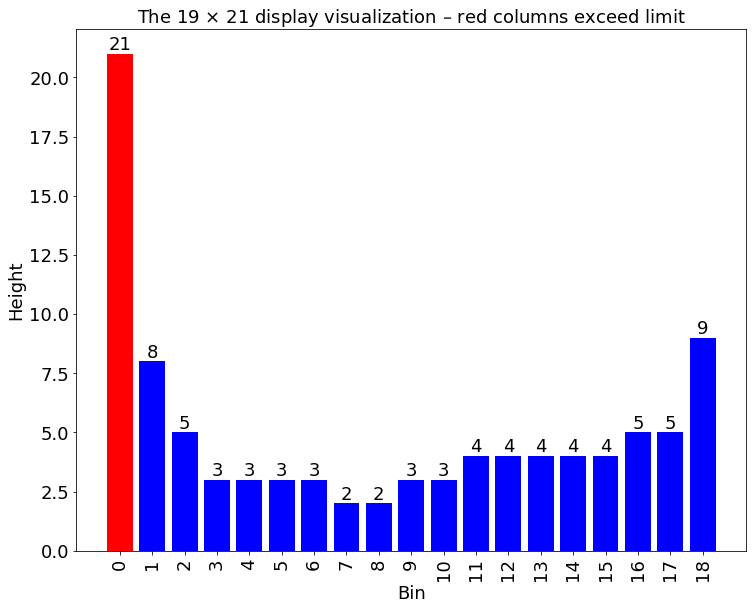

In [336]:
columns_values = [0]*bands_count
display_gain = 18
display_height = 21

for idx, mag in enumerate(mags):
  columns_values[bins[idx]] += mag

heights = [cv*display_gain for cv in columns_values]

colors = ['blue' if height_v < display_height else 'red' for height_v in heights]
heights = [round(min(height_v, display_height)) for height_v in heights]

bars = plt.bar([str(i) for i in range(bands_count)], heights, color=colors)

for rect in bars:
    plt.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), '%d' % int(rect.get_height()), ha='center', va='bottom', fontsize=18)

plt.xticks(fontsize= 18, rotation=90)
plt.yticks(fontsize= 18)
plt.title(f"The {bands_count} " + r"$\times$" + f" {display_height} display visualization – red columns exceed limit", fontsize=18)
plt.ylabel('Height', fontsize=18)
plt.xlabel('Bin', fontsize=18);
plt.show()



## Output bins

In [337]:
variable_name_bins_count = "BINS_COUNT"
print(f"#define {variable_name_bins_count} {len(bins)}")
print(f"const int bins[{variable_name_bins_count}] = " + "{" + str(bins)[1:-1] + "};\n")

#define BINS_COUNT 512
const int bins[BINS_COUNT] = {0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1

# Comparison datas

Time-based and frequency-based datas. Copy-paste to embedded system project.

In [353]:
variable_name_test_samples_count = "TEST_SAMPLES_COUNT"
print(f"// Data generated using Jupyter Notebook. The signal mixes {frequency_1} Hz, {frequency_2} Hz and white noise.")
print(f"#define {variable_name_test_samples_count} {len(val)}")
print(f"const float32_t test_signal[{variable_name_test_samples_count}] = " + "{" + str([round(v, 4) for v in val.astype('float32').tolist()])[1:-1] + "};\n")

// Data generated using Jupyter Notebook. The signal mixes 30 Hz, 19999 Hz and white noise.
#define TEST_SAMPLES_COUNT 1024
const float test_signal[TEST_SAMPLES_COUNT] = {0.1624, -0.0287, -0.0983, -0.0188, 0.0127, -0.1097, 0.1012, 0.0448, -0.0093, 0.0676, 0.161, -0.1591, 0.0475, -0.037, 0.249, -0.1368, 0.1503, -0.114, 0.1721, 0.0642, 0.0293, 0.1764, 0.184, 0.1771, 0.1384, 0.1143, 0.0077, 0.1209, -0.006, 0.2677, -0.0163, 0.1464, 0.0402, 0.0559, 0.1067, 0.0936, 0.1178, 0.0901, 0.4271, 0.1416, 0.2421, 0.0108, 0.1578, 0.3248, 0.1918, 0.1567, 0.1603, 0.486, 0.125, 0.3692, 0.1437, 0.2722, 0.0316, 0.2436, 0.181, 0.2913, 0.3504, 0.2801, 0.3506, 0.2473, 0.2779, 0.2848, 0.4044, 0.1618, 0.3729, 0.24, 0.3912, 0.4642, 0.4509, 0.2279, 0.0596, 0.3482, 0.2208, 0.4858, 0.2684, 0.1667, 0.2621, 0.4056, 0.3802, 0.3532, 0.3901, 0.2286, 0.4619, 0.2903, 0.4624, 0.2933, 0.3461, 0.3749, 0.3791, 0.5144, 0.4408, 0.475, 0.255, 0.4232, 0.3355, 0.494, 0.2907, 0.4609, 0.3188, 0.4799, 0.4002, 0.4865, 0.5401, 0.3949, 

In [356]:
out_mags = np.abs(sig_fft_real + 1j*sig_fft_imag)
assert(len(out_mags) == len(val))
print(f"// Len of mags = {len(out_mags)} should be equal to len of time samples = {len(val)}. Use half.")
print(f"const float32_t test_megs[{variable_name_test_samples_count}] = " + "{" + str([round(mg, 4) for mg in out_mags.astype('float32').tolist()])[1:-1] + "};\n")

// Len of mags = 1024 should be equal to len of time samples = 1024. Use half.
const float32_t test_megs[TEST_SAMPLES_COUNT] = {311.6108, 420.9747, 98.1827, 58.7931, 42.6959, 34.219, 27.1659, 22.0502, 23.3506, 17.9231, 15.8833, 14.1972, 12.3149, 9.6207, 10.1801, 9.0002, 8.7943, 10.5024, 10.5264, 5.5023, 11.1991, 4.9225, 7.8062, 7.1913, 13.1039, 4.4101, 9.9518, 6.3973, 6.7241, 3.149, 4.5222, 0.6644, 4.6058, 7.3791, 6.3518, 2.9223, 4.0499, 2.7941, 4.9068, 6.0233, 4.4422, 4.77, 3.4824, 5.504, 5.6993, 3.8774, 1.5853, 6.0804, 4.3953, 5.0896, 4.2738, 8.0319, 3.4311, 7.9545, 4.4783, 5.2772, 1.7574, 6.4118, 4.0888, 7.6756, 5.3031, 1.6197, 3.8307, 4.2655, 2.3716, 0.722, 9.7994, 2.1851, 2.4172, 5.9522, 1.7307, 3.1994, 4.5306, 4.7869, 2.3295, 1.4003, 4.6656, 3.0256, 1.1518, 1.6292, 4.0426, 2.7388, 0.8741, 3.3136, 2.3722, 4.3943, 0.6707, 2.1085, 4.6515, 2.259, 2.5692, 3.0955, 1.0122, 9.0954, 2.2558, 2.0602, 3.2562, 1.8393, 1.2012, 0.6562, 0.3439, 0.9197, 3.9044, 1.451, 2.188, 5.0063, 1.3889, 4.049

# IFFT check - frequency domain

The comparison of FFT evaluated using scipy and evaluated on embedded system.

Time samples count: (1024,)
FFT output samples, real part count: (1024,)
FFT output samples, imaginary part count: (1024,)
To check rersults fill the arrays (of length 1024) from output of embedded system.


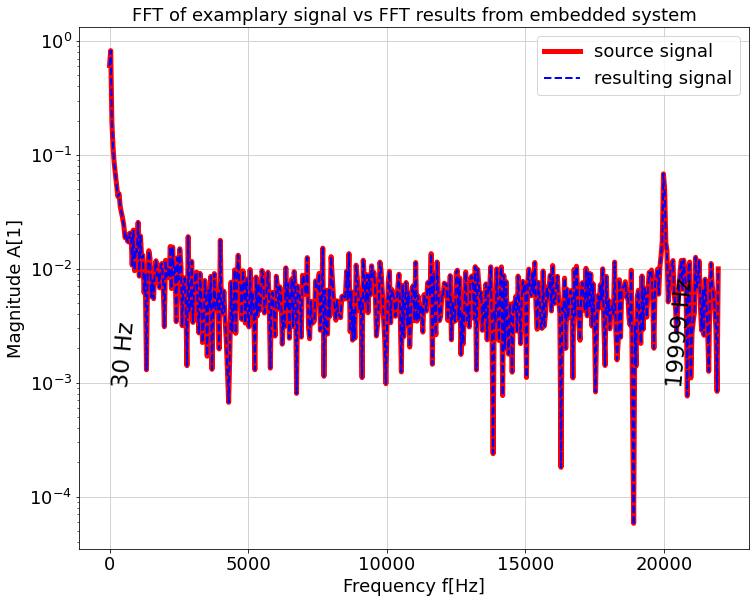

In [339]:
print(f"Time samples count: {t.shape}")
xf = sampling_frequency*np.arange(samples_count//2)/samples_count

print(f"FFT output samples, real part count: {sig_fft_real.shape}")
print(f"FFT output samples, imaginary part count: {sig_fft_imag.shape}")
sig_fft = sig_fft_real + 1j*sig_fft_imag
source_mags = 2.0/samples_count * np.abs(sig_fft_real + 1j*sig_fft_imag)[:samples_count//2]

print(f"To check rersults fill the arrays (of length {len(t)}) from output of embedded system.")

# Fill those arrays with readings, full length equal 'samples_count'
res_fft_real = np.array([311.611298, -292.625244, -42.907005, -22.194689, -11.453762, -5.754398, -4.920623, -1.781957, -7.162320, -2.998394, -0.726078, 0.682367, 0.495269, -1.052336, 1.215669, -2.128953, 1.661377, -2.228601, 0.329934, 0.775770, -0.313245, -1.929369, 0.377885, 1.465248, 0.496240, -2.655761, -0.771508, 3.092270, 2.422315, 0.107368, -2.131090, 0.223483, -1.882649, 2.654434, -1.654583, 2.098518, 2.024106, -1.686486, 1.296338, -5.411964, -4.031675, 2.383361, 1.513209, -0.841195, 1.777523, -2.518124, 0.373216, 0.171335, 2.340304, 2.677005, 3.743984, -3.690600, 1.427085, 2.884010, -3.249595, 1.027476, -1.527872, 0.491883, -3.039155, 3.375965, 1.864916, 1.039497, 1.388837, 1.076570, -2.362334, -0.721272, 3.830387, 1.738976, -1.412025, 1.639094, -1.728061, -1.349480, 3.445386, 0.250504, 2.255381, 1.350081, -1.149675, 2.891124, -0.849592, 1.335959, 4.041578, -1.751139, 0.842138, -0.469274, 2.360181, -0.502625, 0.003524, 1.304855, 0.406382, 1.179369, 1.752008, 2.876459, 0.929752, 3.930071, 1.138327, -1.423446, -0.644100, 1.079174, 1.156588, 0.539057, -0.060991, -0.307654, 2.898792, -1.446284, -2.137587, 3.635488, 0.143959, 3.872165, 1.803932, 1.393999, 2.651367, -0.196923, 4.876979, 0.640091, 0.955009, -2.259264, -1.237029, -0.587247, 0.034412, -1.240956, 2.416647, -0.491878, 0.202686, 4.139500, 0.884916, -2.083243, 1.864353, 2.320971, 4.774825, 4.304926, -2.086738, 2.472476, 1.970929, 2.485559, 0.171447, -0.678633, 2.484445, 3.176571, 1.301530, -1.212439, 4.391558, 2.202036, 1.151212, 2.463017, -0.732129, 0.598465, -1.801321, 1.250752, -3.713418, -2.179866, 2.550830, 1.051983, 2.191556, -4.143819, 1.545613, -1.662811, -0.465166, 0.091553, -2.726326, 2.938906, -2.638760, 0.313609, 4.357162, -1.618214, -2.506861, 1.098318, 4.198050, -0.653863, -0.759810, -1.387710, 0.452343, 1.666125, 1.789890, -1.513576, -1.418706, 0.531040, -3.295039, -0.418501, 0.208320, -5.953188, -0.194434, 2.920175, 0.808302, -0.432560, 2.384996, 0.773746, 3.685921, 0.914651, 0.227699, 0.527597, -1.699550, 2.544930, 1.330034, -1.487853, -1.283374, 2.639940, 2.958005, 0.491723, -0.494525, 4.226021, -0.456320, 5.773912, 0.903852, 0.315787, -1.097833, -2.000161, -0.119621, 1.660769, 4.188684, -0.611757, 2.043187, 2.111385, 0.069690, 5.580765, 2.615927, -0.074951, 1.208638, 2.028624, -2.554395, 1.880265, -5.426829, 4.238167, -1.181203, 0.153813, 1.090545, -0.743924, 1.591446, 2.939580, 4.746238, 2.063825, -1.397007, 0.427139, -0.386370, -0.470084, 0.227501, 2.071660, -1.058452, -1.143022, 2.891825, 2.632542, 0.381553, 2.343987, 1.789631, 4.086557, 0.844520, 0.597589, 2.609925, -0.042795, -1.924085, -3.831443, 1.563949, 2.608068, 0.801798, 1.560269, -2.449730, -2.713486, 1.128494, -5.815285, -1.501616, 2.717874, -1.757338, 1.577791, -0.294221, 0.596548, 1.066467, -2.610956, -2.121713, 3.440333, 3.553398, 1.522823, 5.456658, 0.593034, -3.272110, 0.863917, -1.204036, 5.299626, -1.310063, 1.709102, -0.892331, 0.444798, -0.449919, 2.789773, 0.726468, 3.193794, 1.779721, 2.085948, 4.287406, -0.373145, 1.475723, -2.042904, 1.056243, 4.734046, 4.507919, -0.747666, 3.892265, 0.559079, -1.947878, -0.557660, 1.816730, -0.245814, -0.326808, -0.527961, 0.629118, 4.177204, 4.340639, -3.405348, 1.282085, 3.009815, 0.185511, 4.596805, 0.774231, 1.318826, -2.540918, 0.766229, -0.549441, 1.585419, 2.111194, -1.114295, 2.107270, 3.204798, -4.979491, 0.647622, -0.102446, 1.254030, -0.636261, -0.776772, 1.927064, -1.200150, 4.381665, 3.839912, 0.389654, 4.475789, -0.108751, 3.924702, 1.315099, -0.454745, 0.956469, -1.165458, -0.219145, -0.040312, -2.243984, -0.819291, -0.728291, 1.730365, -0.448670, 0.977211, -0.258871, 1.977028, 1.399404, 2.806057, -0.329494, 3.713469, 3.646910, 2.033436, -2.331798, -0.266465, -1.696428, -1.536832, -0.025444, 1.502364, -1.439382, 0.588186, 0.899143, -0.990190, 0.649631, 0.484978, 1.499596, -1.665691, 1.863716, -2.382792, -0.269420, -1.739990, 4.847990, 1.446013, -1.450150, 3.294058, 2.802518, 1.826992, 1.943910, -0.052573, -1.682224, 0.882728, 3.800284, 0.361146, 3.158372, -0.627422, 2.928541, -1.891828, 2.926149, -0.434347, 4.133577, 1.401852, 5.323957, -2.893291, -1.189430, 1.204397, -0.542096, 3.400132, -2.793236, -1.394950, 2.462317, 0.400955, -4.602022, -0.174677, 0.231754, 1.256563, 3.687465, -1.428089, -0.317405, -1.755073, -1.855487, -2.161357, -3.037103, 2.728755, 5.007302, 1.424175, 0.321543, 4.255516, 0.452085, 0.323111, -1.043195, 0.872690, 0.314171, 1.856775, 5.581878, -1.014213, -0.810145, 0.331060, 0.125656, -0.060751, 2.992653, -2.000724, 2.865522, 3.935015, 1.606526, 0.711375, 1.939897, 1.605752, 0.977372, 0.320430, 0.026153, 1.230233, 0.007152, -0.899058, 3.322275, 0.519220, 0.879247, -4.407917, -0.786205, 2.859600, 0.577897, 0.075982, 0.273736, 4.742134, 3.805999, -4.016666, 2.175663, -0.545627, 3.653893, 4.241820, 4.597775, 0.399231, 5.050837, 6.459835, 8.878182, 34.148865, -25.818802, -7.280944, -6.746828, -2.504431, 1.220023, -5.222439, -5.416531, -1.285609, -0.484950, -2.379953, 0.793757, 0.442787, -2.982949, 3.826486, -3.714015, -2.023714, 0.412637, -4.011794, 3.383533, 0.343728, 1.580173, 0.861278, 0.109824, -0.887007, -1.614865, -1.877780, 2.193408, 2.974956, -1.598517, 3.394705, -0.058844, -1.371399, 1.355451, 1.141469, 4.132510, 2.450890, -0.191219, -0.157688, 2.924331, 1.261854, 1.655912, -0.200484, 2.187258, -1.085905, -0.297886, 5.030472, 0.886902, 5.030472, -0.297886, -1.085903, 2.187259, -0.200482, 1.655912, 1.261854, 2.924331, -0.157690, -0.191218, 2.450892, 4.132511, 1.141470, 1.355450, -1.371403, -0.058844, 3.394703, -1.598518, 2.974955, 2.193408, -1.877781, -1.614864, -0.887006, 0.109823, 0.861281, 1.580172, 0.343728, 3.383533, -4.011796, 0.412637, -2.023713, -3.714015, 3.826490, -2.982950, 0.442787, 0.793757, -2.379953, -0.484950, -1.285606, -5.416531, -5.222439, 1.220023, -2.504430, -6.746828, -7.280944, -25.818802, 34.148865, 8.878182, 6.459834, 5.050836, 0.399231, 4.597775, 4.241820, 3.653893, -0.545626, 2.175663, -4.016665, 3.805999, 4.742132, 0.273735, 0.075982, 0.577897, 2.859607, -0.786205, -4.407922, 0.879246, 0.519221, 3.322274, -0.899059, 0.007152, 1.230232, 0.026153, 0.320430, 0.977372, 1.605752, 1.939897, 0.711376, 1.606525, 3.935016, 2.865522, -2.000723, 2.992653, -0.060753, 0.125656, 0.331060, -0.810145, -1.014213, 5.581878, 1.856775, 0.314171, 0.872689, -1.043195, 0.323113, 0.452084, 4.255513, 0.321543, 1.424176, 5.007302, 2.728759, -3.037102, -2.161357, -1.855487, -1.755072, -0.317405, -1.428089, 3.687465, 1.256564, 0.231754, -0.174679, -4.602021, 0.400957, 2.462317, -1.394946, -2.793236, 3.400129, -0.542096, 1.204395, -1.189430, -2.893290, 5.323956, 1.401854, 4.133576, -0.434347, 2.926149, -1.891826, 2.928540, -0.627437, 3.158372, 0.361135, 3.800284, 0.882726, -1.682225, -0.052573, 1.943909, 1.826991, 2.802518, 3.294061, -1.450150, 1.446015, 4.847990, -1.739990, -0.269419, -2.382793, 1.863716, -1.665690, 1.499597, 0.484979, 0.649632, -0.990190, 0.899143, 0.588184, -1.439381, 1.502363, -0.025444, -1.536832, -1.696428, -0.266463, -2.331799, 2.033432, 3.646911, 3.713476, -0.329494, 2.806057, 1.399404, 1.977026, -0.258871, 0.977213, -0.448670, 1.730366, -0.728291, -0.819291, -2.243983, -0.040312, -0.219144, -1.165462, 0.956469, -0.454746, 1.315099, 3.924702, -0.108751, 4.475790, 0.389653, 3.839912, 4.381664, -1.200153, 1.927064, -0.776772, -0.636261, 1.254030, -0.102446, 0.647624, -4.979491, 3.204794, 2.107269, -1.114298, 2.111194, 1.585417, -0.549441, 0.766228, -2.540918, 1.318828, 0.774231, 4.596805, 0.185511, 3.009819, 1.282085, -3.405351, 4.340639, 4.177201, 0.629117, -0.527960, -0.326808, -0.245814, 1.816729, -0.557661, -1.947878, 0.559077, 3.892264, -0.747666, 4.507920, 4.734044, 1.056245, -2.042899, 1.475723, -0.373144, 4.287407, 2.085949, 1.779721, 3.193792, 0.726468, 2.789775, -0.449918, 0.444798, -0.892331, 1.709103, -1.310063, 5.299626, -1.204036, 0.863921, -3.272110, 0.593035, 5.456658, 1.522824, 3.553399, 3.440333, -2.121712, -2.610958, 1.066468, 0.596547, -0.294220, 1.577789, -1.757338, 2.717872, -1.501616, -5.815292, 1.128494, -2.713478, -2.449728, 1.560269, 0.801798, 2.608068, 1.563949, -3.831442, -1.924084, -0.042794, 2.609925, 0.597589, 0.844520, 4.086556, 1.789631, 2.343986, 0.381553, 2.632542, 2.891825, -1.143024, -1.058452, 2.071657, 0.227500, -0.470084, -0.386370, 0.427138, -1.397007, 2.063823, 4.746239, 2.939581, 1.591448, -0.743927, 1.090544, 0.153818, -1.181203, 4.238168, -5.426829, 1.880267, -2.554395, 2.028620, 1.208638, -0.074950, 2.615927, 5.580765, 0.069690, 2.111384, 2.043187, -0.611758, 4.188684, 1.660771, -0.119621, -2.000162, -1.097833, 0.315788, 0.903852, 5.773910, -0.456320, 4.226019, -0.494525, 0.491723, 2.958005, 2.639940, -1.283373, -1.487853, 1.330034, 2.544926, -1.699549, 0.527597, 0.227699, 0.914652, 3.685921, 0.773743, 2.384996, -0.432563, 0.808302, 2.920176, -0.194435, -5.953188, 0.208319, -0.418504, -3.295039, 0.531038, -1.418706, -1.513575, 1.789890, 1.666124, 0.452343, -1.387710, -0.759810, -0.653864, 4.198050, 1.098317, -2.506860, -1.618215, 4.357161, 0.313611, -2.638760, 2.938900, -2.726327, 0.091553, -0.465166, -1.662810, 1.545613, -4.143822, 2.191556, 1.051981, 2.550830, -2.179863, -3.713418, 1.250752, -1.801321, 0.598465, -0.732129, 2.463016, 1.151211, 2.202037, 4.391558, -1.212439, 1.301530, 3.176570, 2.484446, -0.678632, 0.171447, 2.485560, 1.970929, 2.472475, -2.086736, 4.304923, 4.774825, 2.320964, 1.864354, -2.083242, 0.884915, 4.139501, 0.202686, -0.491879, 2.416647, -1.240957, 0.034412, -0.587248, -1.237029, -2.259264, 0.955008, 0.640088, 4.876979, -0.196922, 2.651367, 1.393999, 1.803931, 3.872166, 0.143959, 3.635488, -2.137588, -1.446284, 2.898792, -0.307653, -0.060991, 0.539059, 1.156587, 1.079169, -0.644099, -1.423442, 1.138327, 3.930073, 0.929752, 2.876458, 1.752008, 1.179369, 0.406381, 1.304852, 0.003524, -0.502625, 2.360180, -0.469271, 0.842137, -1.751146, 4.041578, 1.335955, -0.849593, 2.891125, -1.149676, 1.350081, 2.255380, 0.250502, 3.445386, -1.349481, -1.728061, 1.639094, -1.412025, 1.738976, 3.830386, -0.721275, -2.362335, 1.076565, 1.388838, 1.039497, 1.864916, 3.375966, -3.039154, 0.491882, -1.527872, 1.027476, -3.249595, 2.884009, 1.427085, -3.690598, 3.743984, 2.677004, 2.340304, 0.171337, 0.373213, -2.518122, 1.777523, -0.841197, 1.513209, 2.383360, -4.031675, -5.411967, 1.296337, -1.686484, 2.024106, 2.098515, -1.654584, 2.654434, -1.882649, 0.223484, -2.131090, 0.107368, 2.422315, 3.092269, -0.771508, -2.655760, 0.496240, 1.465247, 0.377885, -1.929369, -0.313245, 0.775770, 0.329935, -2.228599, 1.661377, -2.128951, 1.215668, -1.052336, 0.495269, 0.682366, -0.726078, -2.998395, -7.162320, -1.781958, -4.920622, -5.754397, -11.453762, -22.194691, -42.907005, -292.625244])

res_fft_imag = np.array([0.000000, -302.636566, -88.309692, -54.442841, -41.131378, -33.732571, -26.717024, -21.978188, -22.225199, -17.670933, -15.867553, -14.180389, -12.305467, -9.561964, -10.107595, -8.745087, -8.636599, -10.263109, -10.520631, -5.447546, -11.194476, -4.528053, -7.797060, -7.040549, -13.094584, -3.521971, -9.920673, -5.600082, -6.273277, -3.147663, -3.987060, -0.625313, -4.203619, -6.885139, -6.133662, -2.033691, -3.507513, -2.228297, -4.733035, -2.644654, -1.866693, -4.132017, -3.137158, -5.438855, -5.415594, -2.947626, 1.541284, -6.078149, -3.719555, -4.329412, -2.060433, -7.135444, -3.120446, -7.413504, -3.082151, -5.175654, -0.865246, -6.392465, -2.735208, -6.894217, -4.963874, -1.242265, -3.570228, -4.128122, -0.203474, -0.028411, -9.019121, 1.322775, -1.962538, -5.722914, -0.100319, -2.901000, -2.940836, -4.780615, 0.588172, 0.368637, -4.522147, -0.890976, 0.777907, -0.934040, -0.020518, -2.105892, -0.235800, -3.280103, -0.236463, -4.366034, 0.670925, 1.656141, -4.633415, -1.927314, -1.879222, 1.142472, 0.400937, -8.202911, -1.946687, -1.490116, -3.191326, -1.489342, -0.323739, 0.374173, 0.338781, 0.866955, -2.614878, -0.122441, 0.466844, -3.441174, 1.381789, -1.186383, -6.484359, -3.649279, 2.362062, -1.827925, -0.578730, -3.657607, -1.414426, -3.502888, 1.743615, -1.467527, -5.046411, 1.617497, -1.900680, -2.154959, 0.633471, 1.289029, 1.761037, -3.218597, -1.165173, 1.475707, -1.291972, -0.901628, -0.181316, -0.378230, 2.894409, -4.072790, 2.753472, -0.115547, 1.736858, 0.025187, -1.574841, -0.511383, -0.340312, -2.893344, -1.953870, 2.553674, 2.919828, -0.940651, 0.866199, 0.979502, -3.668651, -0.679749, -2.778990, -0.686115, 1.753283, 0.585178, 0.409742, -4.542283, -3.479505, 0.401663, -2.356404, -1.103518, -0.902509, -1.247544, 1.100545, -4.055382, 2.404075, -2.842027, 4.863511, -1.422015, -0.985471, -2.257055, -1.637675, -0.424435, -0.002976, -3.714661, -3.401759, -3.376277, -3.309992, 1.413231, -2.386369, 4.994178, -0.549016, -1.558964, -1.213866, -1.295301, -2.358796, -1.800346, -5.409265, -4.285507, -2.844359, -2.344925, 0.616168, 0.843250, -1.485409, -1.386877, -1.408885, -1.251382, 0.031515, -2.726763, -2.907142, -2.448842, -2.742016, 3.884369, -1.115068, -3.203675, 0.510152, 0.960392, 1.251794, 5.256989, 0.842887, -2.834101, 0.786071, 1.881352, 0.562853, 2.442549, 3.194334, -2.567808, -4.368201, 0.561395, 3.731453, -2.369578, -0.379904, -0.975295, -4.606339, -3.481180, -0.735984, -1.473382, 1.932303, -5.070907, 1.206237, -2.551700, 1.322952, 1.161899, -0.320826, 1.629824, -3.892380, 4.412284, -1.353758, -3.169337, -0.907244, -1.017703, -1.921231, 0.490941, -3.103282, -2.083418, -1.948071, -0.220052, -2.551178, -1.295449, 1.990621, -0.621184, -0.514153, -1.801997, -0.679010, 1.154026, 2.482788, -2.422791, 1.395401, -0.007217, 0.946995, -1.159566, 0.647716, -1.924929, -2.277499, -1.291986, -2.838758, -0.373759, -0.482375, -1.719345, -1.695251, -2.454357, -4.317225, 0.447532, 3.391165, -1.706470, 0.605946, 2.538867, -2.917770, -0.544122, -1.749590, 3.047056, 2.936705, -2.614024, 3.647980, -1.945520, 0.284122, 1.488881, 1.229795, -1.159219, -2.168504, 0.379754, -1.423216, 0.515069, 2.096022, 1.680883, -1.715632, -0.712308, -0.705677, -0.969149, 1.769198, 4.802441, 1.767718, -2.313959, -1.448572, -0.086967, -0.847055, -2.495892, -1.364275, 4.417727, 0.636089, 2.117964, -3.734119, 2.550579, -1.886245, 1.258796, -2.511961, 1.061110, 3.127343, 0.493315, 3.062168, -0.817626, -1.903587, 1.507286, 0.067747, -1.831167, -1.604872, -5.053135, 0.873437, -0.049954, 0.081248, -3.684918, -0.067473, -0.176526, 1.015819, -0.414965, -0.614379, -0.789231, -2.320247, -1.520990, 0.595054, -2.567517, -0.278777, -2.813633, 1.261463, -4.069162, -2.367977, -0.563171, 2.749373, 3.443023, -2.873680, -2.348759, -0.464804, -0.723358, -3.546684, -2.442591, 1.839483, 4.657156, -2.624460, -5.613554, 2.376498, 0.102913, -3.614703, -2.875800, 1.286618, -1.173821, -4.850230, -1.529165, 1.408052, 3.131152, -2.084178, -2.607050, -4.489964, 1.315075, -2.537338, -2.077928, 2.105998, 1.343899, 3.392766, -2.093540, -0.780850, -0.076253, -1.610161, -1.957829, 1.881066, 0.959271, -1.232966, 1.789359, -0.130156, -2.685390, -0.687883, -0.360000, -2.938947, 1.413230, -0.865880, -1.439985, 1.134193, 0.054706, 3.150319, -1.858081, 0.093898, -1.697783, 4.551322, -1.935373, 1.014264, -2.303542, -4.610690, -0.997177, -0.845389, 1.599996, -0.284169, 0.119409, -2.334126, -0.804277, -2.113292, -0.256938, -1.079496, -0.617678, 0.648746, 1.108510, -1.957312, 2.675407, 1.105366, -2.045752, 2.393747, 0.896777, 1.799760, 1.080698, -0.025827, -1.096039, 4.101572, -1.275829, -1.580058, 2.901042, 2.144382, -0.312784, -2.379678, 3.041779, -0.124886, 0.318226, -4.868503, -0.109016, 0.012012, 1.068615, 0.715949, -2.766316, -0.044894, 1.676468, 0.713141, -0.419424, -1.281251, -1.946817, 3.055473, -1.919689, -3.353291, -0.385743, 2.336959, -2.969604, 1.185146, -0.869103, -1.350851, 0.004376, -2.169569, -3.038521, -1.757146, 1.559311, 1.567218, -7.184972, 1.925169, 4.700711, 2.919142, 0.764239, -3.663738, 0.390362, -0.723551, 5.908209, 3.019276, 0.652765, 1.212113, -2.248734, 1.683637, 3.119439, 4.795312, -2.712575, 6.091879, -2.276602, 0.376006, 0.188568, -4.883198, 5.808482, 0.553472, -1.092784, 0.713979, -0.970652, 6.076786, -1.850786, 3.843865, 4.937591, -2.406186, 0.543663, 3.075313, -0.692085, 0.324625, -1.006277, 1.575967, -0.625462, 0.925951, 5.557957, -3.215598, -3.012500, -0.795960, -1.122220, -0.308760, -0.889091, 0.000000, 0.889069, 0.308758, 1.122219, 0.795961, 3.012501, 3.215597, -5.557957, -0.925951, 0.625462, -1.575967, 1.006277, -0.324624, 0.692083, -3.075313, -0.543661, 2.406185, -4.937592, -3.843865, 1.850786, -6.076785, 0.970652, -0.713979, 1.092784, -0.553471, -5.808479, 4.883199, -0.188569, -0.376006, 2.276602, -6.091878, 2.712567, -4.795312, -3.119441, -1.683638, 2.248733, -1.212113, -0.652765, -3.019275, -5.908210, 0.723551, -0.390363, 3.663738, -0.764239, -2.919143, -4.700710, -1.925169, 7.184972, -1.567218, -1.559309, 1.757146, 3.038524, 2.169570, -0.004376, 1.350851, 0.869101, -1.185146, 2.969606, -2.336960, 0.385745, 3.353292, 1.919691, -3.055473, 1.946813, 1.281251, 0.419424, -0.713141, -1.676466, 0.044894, 2.766315, -0.715949, -1.068615, -0.012012, 0.109017, 4.868503, -0.318225, 0.124886, -3.041778, 2.379677, 0.312782, -2.144383, -2.901045, 1.580057, 1.275829, -4.101572, 1.096038, 0.025827, -1.080698, -1.799760, -0.896777, -2.393747, 2.045750, -1.105366, -2.675407, 1.957312, -1.108510, -0.648746, 0.617672, 1.079496, 0.256938, 2.113293, 0.804278, 2.334126, -0.119409, 0.284169, -1.599999, 0.845389, 0.997177, 4.610691, 2.303539, -1.014263, 1.935373, -4.551322, 1.697782, -0.093898, 1.858083, -3.150319, -0.054708, -1.134193, 1.439983, 0.865881, -1.413230, 2.938948, 0.360003, 0.687884, 2.685388, 0.130157, -1.789359, 1.232966, -0.959266, -1.881066, 1.957827, 1.610162, 0.076255, 0.780850, 2.093543, -3.392766, -1.343900, -2.105999, 2.077927, 2.537339, -1.315072, 4.489964, 2.607051, 2.084178, -3.131151, -1.408052, 1.529166, 4.850229, 1.173822, -1.286618, 2.875801, 3.614702, -0.102912, -2.376498, 5.613552, 2.624461, -4.657156, -1.839482, 2.442589, 3.546684, 0.723357, 0.464804, 2.348758, 2.873681, -3.443024, -2.749374, 0.563171, 2.367977, 4.069162, -1.261463, 2.813632, 0.278777, 2.567517, -0.595052, 1.520991, 2.320247, 0.789231, 0.614379, 0.414966, -1.015819, 0.176526, 0.067473, 3.684918, -0.081248, 0.049955, -0.873438, 5.053136, 1.604873, 1.831165, -0.067746, -1.507290, 1.903587, 0.817625, -3.062169, -0.493314, -3.127342, -1.061112, 2.511961, -1.258795, 1.886245, -2.550579, 3.734118, -2.117965, -0.636089, -4.417726, 1.364275, 2.495890, 0.847055, 0.086968, 1.448571, 2.313956, -1.767718, -4.802440, -1.769198, 0.969149, 0.705677, 0.712310, 1.715631, -1.680882, -2.096021, -0.515067, 1.423216, -0.379754, 2.168504, 1.159215, -1.229794, -1.488879, -0.284122, 1.945518, -3.647979, 2.614023, -2.936705, -3.047056, 1.749590, 0.544124, 2.917770, -2.538868, -0.605946, 1.706471, -3.391165, -0.447535, 4.317225, 2.454360, 1.695251, 1.719343, 0.482376, 0.373762, 2.838757, 1.291986, 2.277500, 1.924932, -0.647716, 1.159566, -0.946989, 0.007225, -1.395401, 2.422806, -2.482788, -1.154025, 0.679009, 1.801997, 0.514154, 0.621179, -1.990622, 1.295448, 2.551178, 0.220052, 1.948072, 2.083418, 3.103283, -0.490942, 1.921231, 1.017705, 0.907244, 3.169337, 1.353757, -4.412284, 3.892380, -1.629826, 0.320826, -1.161900, -1.322953, 2.551702, -1.206237, 5.070906, -1.932302, 1.473381, 0.735984, 3.481181, 4.606341, 0.975295, 0.379903, 2.369581, -3.731454, -0.561393, 4.368202, 2.567806, -3.194333, -2.442551, -0.562853, -1.881353, -0.786072, 2.834103, -0.842887, -5.256989, -1.251794, -0.960393, -0.510152, 3.203677, 1.115068, -3.884369, 2.742016, 2.448844, 2.907142, 2.726763, -0.031515, 1.251382, 1.408886, 1.386874, 1.485409, -0.843253, -0.616167, 2.344926, 2.844360, 4.285507, 5.409264, 1.800344, 2.358796, 1.295302, 1.213867, 1.558962, 0.549015, -4.994179, 2.386369, -1.413233, 3.309992, 3.376281, 3.401760, 3.714661, 0.002976, 0.424433, 1.637675, 2.257054, 0.985471, 1.422013, -4.863511, 2.842026, -2.404075, 4.055380, -1.100545, 1.247543, 0.902509, 1.103513, 2.356403, -0.401665, 3.479505, 4.542286, -0.409743, -0.585178, -1.753283, 0.686113, 2.778990, 0.679749, 3.668651, -0.979500, -0.866199, 0.940652, -2.919828, -2.553669, 1.953869, 2.893345, 0.340312, 0.511384, 1.574841, -0.025187, -1.736858, 0.115547, -2.753472, 4.072788, -2.894409, 0.378232, 0.181316, 0.901622, 1.291972, -1.475723, 1.165172, 3.218598, -1.761039, -1.289028, -0.633472, 2.154960, 1.900680, -1.617498, 5.046411, 1.467529, -1.743614, 3.502887, 1.414425, 3.657602, 0.578730, 1.827927, -2.362062, 3.649277, 6.484359, 1.186383, -1.381790, 3.441175, -0.466843, 0.122444, 2.614878, -0.866954, -0.338782, -0.374172, 0.323738, 1.489341, 3.191326, 1.490115, 1.946686, 8.202909, -0.400938, -1.142470, 1.879222, 1.927313, 4.633415, -1.656144, -0.670925, 4.366034, 0.236462, 3.280102, 0.235799, 2.105894, 0.020518, 0.934042, -0.777907, 0.890976, 4.522147, -0.368636, -0.588171, 4.780615, 2.940836, 2.901002, 0.100319, 5.722913, 1.962538, -1.322774, 9.019119, 0.028411, 0.203474, 4.128123, 3.570228, 1.242267, 4.963874, 6.894217, 2.735208, 6.392466, 0.865246, 5.175657, 3.082151, 7.413501, 3.120446, 7.135445, 2.060433, 4.329408, 3.719556, 6.078146, -1.541284, 2.947624, 5.415594, 5.438855, 3.137159, 4.132018, 1.866693, 2.644654, 4.733036, 2.228293, 3.507513, 2.033689, 6.133661, 6.885134, 4.203619, 0.625315, 3.987059, 3.147664, 6.273277, 5.600080, 9.920673, 3.521971, 13.094584, 7.040549, 7.797060, 4.528054, 11.194476, 5.447545, 10.520630, 10.263105, 8.636599, 8.745088, 10.107594, 9.561962, 12.305467, 14.180390, 15.867552, 17.670929, 22.225197, 21.978191, 26.717022, 33.732567, 41.131378, 54.442844, 88.309677, 302.636536])

resulting_mags = 2.0/samples_count * np.array([311.611298, 420.973175, 98.181526, 58.793087, 42.696358, 34.219872, 27.166374, 22.050308, 23.350767, 17.923510, 15.884156, 14.196798, 12.315430, 9.619698, 10.180439, 9.000499, 8.794942, 10.502289, 10.525803, 5.502507, 11.198858, 4.921964, 7.806212, 7.191403, 13.103984, 4.411048, 9.950627, 6.397113, 6.724702, 3.149494, 4.520862, 0.664049, 4.605950, 7.379102, 6.352910, 2.922272, 4.049648, 2.794556, 4.907353, 6.023583, 4.442853, 4.770113, 3.483039, 5.503522, 5.699846, 3.876783, 1.585827, 6.080563, 4.394556, 5.090203, 4.273499, 8.033374, 3.431290, 7.954720, 4.478786, 5.276656, 1.755860, 6.411362, 4.088744, 7.676416, 5.302637, 1.619808, 3.830848, 4.266191, 2.371081, 0.721831, 9.798796, 2.184896, 2.417721, 5.953014, 1.730970, 3.199516, 4.529813, 4.787174, 2.330813, 1.399504, 4.666001, 3.025300, 1.151932, 1.630097, 4.041630, 2.738845, 0.874528, 3.313502, 2.371997, 4.394870, 0.670934, 2.108423, 4.651202, 2.259524, 2.569243, 3.095037, 1.012516, 9.095780, 2.255078, 2.060739, 3.255676, 1.839227, 1.201043, 0.656192, 0.344227, 0.919925, 3.903918, 1.451457, 2.187972, 5.005841, 1.389268, 4.049835, 6.730608, 3.906466, 3.550928, 1.838502, 4.911197, 3.713193, 1.706646, 4.168273, 2.137857, 1.580663, 5.046528, 2.038693, 3.074535, 2.210383, 0.665107, 4.335557, 1.970870, 3.833963, 2.198509, 2.750386, 4.946528, 4.398332, 2.094601, 2.501239, 3.501737, 4.771334, 2.758805, 0.688399, 3.031360, 3.176671, 2.043063, 1.315872, 4.404724, 3.635988, 2.267796, 3.547916, 3.010217, 1.114893, 1.998764, 1.588649, 5.220007, 2.283391, 3.772204, 1.255955, 2.806586, 4.184934, 1.599002, 4.837073, 3.510461, 0.411965, 3.603539, 3.139255, 2.788831, 1.286358, 4.494002, 4.366319, 3.473316, 3.046870, 6.424746, 1.565140, 1.244373, 2.649535, 1.698998, 1.719336, 1.789892, 4.011186, 3.685741, 3.417784, 4.670474, 1.473895, 2.395444, 7.770602, 0.582429, 3.310256, 1.458363, 1.365618, 3.354419, 1.959573, 6.545698, 4.382027, 2.853459, 2.403546, 1.807798, 2.680995, 1.993848, 2.033995, 1.905783, 2.921513, 2.958173, 2.770745, 2.948903, 4.884269, 2.779727, 6.958907, 1.435383, 3.219201, 1.210576, 2.218783, 1.257496, 5.513084, 4.272650, 2.899375, 2.189182, 2.827973, 0.567151, 6.091878, 4.128782, 2.568902, 4.532327, 2.104870, 4.522021, 3.024946, 5.440111, 4.348938, 4.755376, 3.484576, 1.315659, 1.650539, 2.503297, 5.861333, 4.897120, 3.281852, 1.924014, 1.237925, 0.502206, 1.696262, 3.899023, 4.874426, 1.718424, 3.369154, 3.030799, 2.822410, 1.958753, 2.394849, 3.582337, 4.587001, 2.123251, 0.636817, 3.649687, 1.296156, 2.768515, 3.881472, 1.646296, 3.170049, 1.050683, 1.940674, 3.487895, 3.637708, 1.794615, 5.815289, 1.775288, 2.954899, 1.872904, 2.488930, 2.296425, 1.423059, 3.032474, 2.637573, 2.175856, 3.846042, 3.937070, 2.888401, 6.957985, 0.742949, 4.712399, 1.912692, 1.347914, 5.876383, 3.198382, 1.793628, 1.964006, 3.079350, 2.970970, 3.823082, 3.719612, 3.739702, 1.802258, 2.562800, 4.460296, 1.217795, 2.623007, 2.077900, 1.772341, 4.761983, 4.971382, 1.839666, 4.253601, 0.905512, 2.071765, 1.118139, 2.535856, 4.808728, 1.797674, 2.373426, 1.579288, 4.178109, 4.422516, 4.222070, 1.872161, 5.345586, 0.662588, 5.061263, 3.813539, 2.871368, 3.164520, 1.473660, 2.571348, 1.907749, 3.773250, 1.218611, 3.717185, 3.307452, 5.330945, 1.640526, 0.122820, 2.219406, 1.726396, 5.112490, 2.115767, 1.201189, 4.382419, 5.321987, 0.395452, 4.479269, 1.021623, 3.946578, 1.451532, 0.910867, 2.509657, 1.916169, 0.634124, 2.567833, 2.261234, 2.930490, 1.456604, 4.421792, 2.410108, 1.127875, 2.761534, 3.970270, 3.196306, 3.659320, 0.569745, 3.783265, 5.087133, 3.178225, 2.970014, 4.664773, 3.125005, 5.820123, 2.376634, 1.505884, 3.890745, 2.935335, 1.569663, 1.535686, 4.893541, 1.604228, 2.057036, 3.546638, 2.795932, 3.531912, 4.498040, 2.181052, 5.471846, 2.531549, 2.556983, 3.557651, 4.400565, 2.778634, 2.094877, 0.092620, 2.328625, 2.147627, 4.240350, 1.025002, 3.390504, 1.896171, 2.931432, 3.284865, 3.005916, 0.564143, 5.071870, 1.990580, 5.393910, 3.231824, 1.643514, 1.205639, 3.196619, 3.874708, 2.794814, 2.197352, 5.174702, 1.976470, 4.712466, 2.310155, 4.616511, 1.604155, 3.783131, 2.144627, 0.426026, 1.759130, 2.981774, 2.306149, 3.700000, 2.740825, 5.122342, 1.552353, 0.724058, 4.397523, 2.008843, 2.694848, 1.519898, 2.224115, 2.414276, 2.061995, 5.864852, 1.482071, 0.810557, 1.144947, 4.103496, 1.277274, 3.384162, 3.524052, 3.579049, 3.947427, 2.871200, 3.123855, 1.943913, 1.636981, 4.965639, 0.338467, 0.028780, 1.629543, 0.715985, 2.908747, 3.322578, 1.755031, 1.132097, 4.427827, 1.503237, 3.459395, 3.109643, 1.921192, 3.364445, 4.757797, 4.466207, 4.995214, 2.477515, 1.026182, 3.895605, 4.241823, 5.083951, 3.064636, 5.347758, 6.645368, 9.015448, 34.896545, 25.890478, 8.666534, 7.351264, 2.618441, 3.861533, 5.237008, 5.464644, 6.046464, 3.057974, 2.467849, 1.448885, 2.291913, 3.425291, 4.936892, 6.065387, 3.384300, 6.105838, 4.612744, 3.404362, 0.392055, 5.132501, 5.871990, 0.564263, 1.407465, 1.765660, 2.113817, 6.460523, 3.503680, 4.162999, 5.991980, 2.406905, 1.475230, 3.360773, 1.334891, 4.145240, 2.649426, 1.587526, 0.645034, 3.067425, 5.699400, 3.616920, 3.019164, 2.327585, 1.561591, 0.429032, 5.108437])

# plt.xscale("log")
plt.yscale("log")
plt.plot(xf, source_mags, 'r', label='source signal', linewidth=5)
plt.plot(xf, resulting_mags, '--' ,color='b', label='resulting signal', linewidth=2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.grid(color='lightgray', linestyle='-', linewidth=1)
# plt.axvline(x=frequency_1, c="brown")
# plt.axvline(x=frequency_2, c="brown")
plt.text(frequency_1, 1e-3, f"{frequency_1} Hz", fontsize = 23, rotation=85)
plt.text(frequency_2, 1e-3, f"{frequency_2} Hz", fontsize = 23, rotation=85)
plt.xlabel("Frequency f[Hz]", fontsize=18)
plt.ylabel(r'Magnitude A[1]', fontsize=18)
plt.title(r'FFT of examplary signal vs FFT results from embedded system', fontsize=18)
plt.legend(fontsize=18)
plt.show()



# IFFT check - time domain

To recreate time-based signal both imaginary and real parts of output FFT are needed. Original signal is compared with the signal reconstruction using scipy.

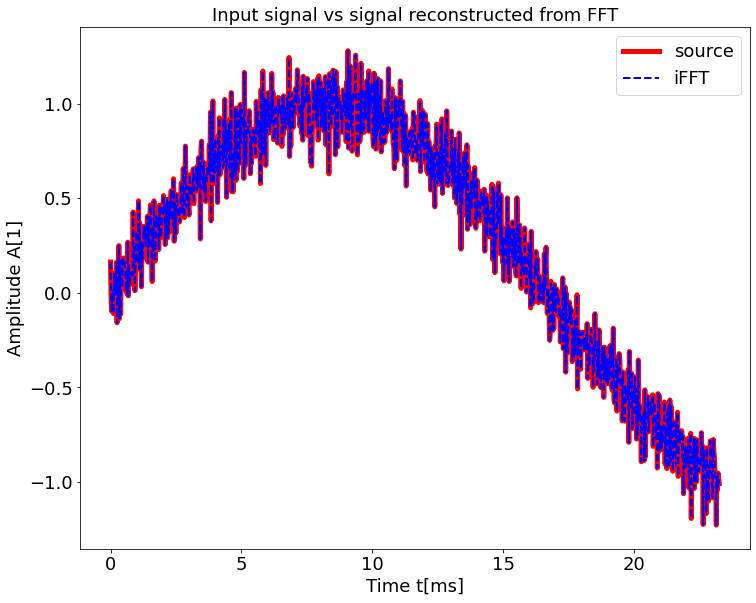

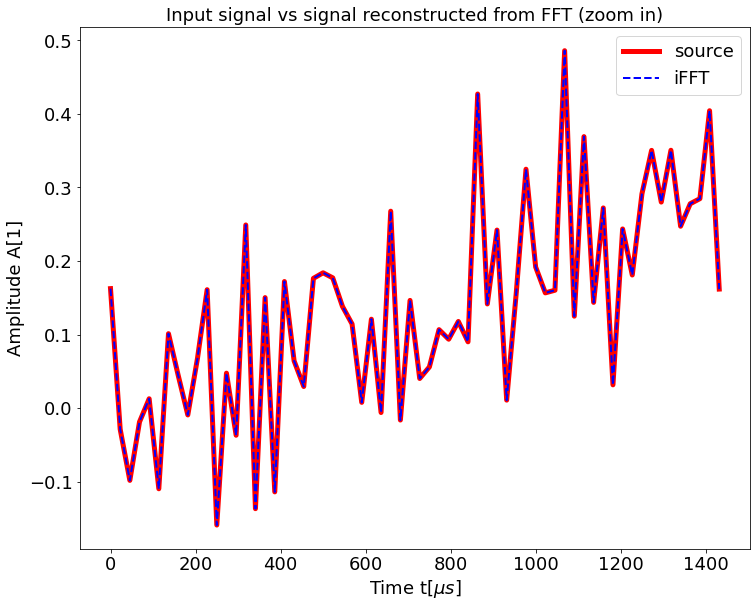

In [340]:
res_fft_cplx = res_fft_real + 1j*res_fft_imag

s = np.fft.ifft(res_fft_cplx)
plt.plot(t*1000, val, label='source', color='r', linewidth=5)
plt.plot(t*1000, s.real, '--', label='iFFT', color='b', linewidth=2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.legend(fontsize=18)
plt.xlabel("Time t[ms]", fontsize=18)
plt.ylabel(r'Amplitude A[1]', fontsize=18)
plt.title("Input signal vs signal reconstructed from FFT", fontsize=18)
plt.show()

zoom_range = len(t)//16
plt.plot(t[:zoom_range]*1e6, val[:zoom_range], label='source', color='r', linewidth=5)
plt.plot(t[:zoom_range]*1e6, s.real[:zoom_range], '--', label='iFFT', color='b', linewidth=2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.legend(fontsize=18)
plt.xlabel(r"Time t[$\mu s$]", fontsize=18)
plt.ylabel(r'Amplitude A[1]', fontsize=18)
plt.title("Input signal vs signal reconstructed from FFT (zoom in)", fontsize=18)
plt.show()

# References

How to use STM32 CMSIS FFT library in STM32CubeIDE's project: 
https://community.st.com/s/article/configuring-dsp-libraries-on-stm32cubeide

Documentation https://www.keil.com/pack/doc/CMSIS/DSP/html/group__ComplexFFT.html

STM32F303VCT6 https://www.st.com/en/microcontrollers-microprocessors/stm32f303vc.html
STM32F446RET6 https://www.st.com/en/microcontrollers-microprocessors/stm32f446re.html
